## Improve readability of subtitles

Simple algorithm to create a .srt file that is able to fit in the qualitative standards of the RaiPlay guidelines (max 37 characters per line, max 2 lines).

This algorithm exploits the fact that for each word we have the associated timestamp


In [ ]:
import matplotlib.pyplot as plt
import re
from utils.names import get_file_names, get_model_names

files = get_file_names()
models = get_model_names()


# Algorithm to build better subtitles

In [ ]:
# --- CONSTANTS FOR RAI SUBTITLES ---
MAX_LEN_LINE = 37       # max chars per line (RAI style)
MAX_LEN_BLOCK = MAX_LEN_LINE * 2  # max chars for 2 lines
MIN_DISPLAY_TIME = 1.0  # min seconds per block
MAX_DISPLAY_TIME = 6.0  # max seconds per block

# --- UTILITY FUNCTIONS ---

def format_srt_time(seconds: float) -> str:
    """Turns float seconds into SRT time format HH:MM:SS,mmm"""
    total_ms = round(seconds * 1000)
    hours = total_ms // 3_600_000
    minutes = (total_ms % 3_600_000) // 60_000
    secs = (total_ms % 60_000) // 1000
    millis = total_ms % 1000
    return f"{hours:02}:{minutes:02}:{secs:02},{millis:03}"

def smart_line_break(text: str) -> str:
    """
    Splits text into max 2 lines:
    - max MAX_LEN_LINE chars per line
    - tries to split on punctuation or space if possible
    """
    text = re.sub(r'\s+', ' ', text.strip())
    if len(text) <= MAX_LEN_LINE:
        return text

    candidates = [m.start() for m in re.finditer(r'[ ,;:.!?]', text)]
    split_pos = None
    for pos in reversed(candidates):
        if pos <= MAX_LEN_LINE:
            split_pos = pos
            break
    if split_pos is None:
        split_pos = MAX_LEN_LINE

    first = text[:split_pos].strip()
    second = text[split_pos:].strip()
    return first + "\n" + second

def merge_apostrophes(words):
    """
    Joins tokens split by apostrophe (like "l" + "'abbiamo" -> "l'abbiamo")
    """
    merged = []
    skip = False
    for i, w in enumerate(words):
        if skip:
            skip = False
            continue
        if i + 1 < len(words) and words[i+1]['word'].startswith("'"):
            merged.append({
                'word': w['word'] + words[i+1]['word'],
                'start': w['start'],
                'end': words[i+1]['end']
            })
            skip = True
        else:
            merged.append(w)
    return merged

# --- MAIN FUNCTION ---

def create_srt_from_json(data_json: list) -> str:
    MIN_GAP = 0.04
    # 1) Basic segmentation into readable blocks
    raw_blocks = []
    for seg in data_json:
        words = merge_apostrophes(seg['words'])
        i = 0
        while i < len(words):
            block_words = []
            block_len = 0
            start_time = words[i]['start']

            while i < len(words):
                w = words[i]['word']
                proposed_len = block_len + (len(w) + (1 if block_len > 0 else 0))
                if proposed_len > MAX_LEN_BLOCK and block_len > 0:
                    break
                block_words.append(words[i])
                block_len = proposed_len
                i += 1

            end_time = block_words[-1]['end']
            text = " ".join(w['word'] for w in block_words)
            text = smart_line_break(text)

            # Temporary min/max duration
            duration = end_time - start_time
            if duration < MIN_DISPLAY_TIME:
                end_time = start_time + MIN_DISPLAY_TIME
            elif duration > MAX_DISPLAY_TIME:
                end_time = start_time + MAX_DISPLAY_TIME

            raw_blocks.append({
                'start': start_time,
                'end': end_time,
                'text': text
            })

    # 2) Try to merge consecutive subtitles if possible
    merged_blocks = []
    idx = 0
    while idx < len(raw_blocks):
        current = raw_blocks[idx]
        start_time = current['start']
        end_time = current['end']
        merged_text = current['text'].replace("\n", " ")
        
        idx += 1
        # Try to merge more blocks if they fit
        while idx < len(raw_blocks):
            next_block = raw_blocks[idx]
            candidate_text = merged_text + " " + next_block['text'].replace("\n", " ")
            candidate_text = re.sub(r'\s+', ' ', candidate_text).strip()
            candidate_end_time = next_block['end']
            total_duration = candidate_end_time - start_time

            if (len(candidate_text) <= MAX_LEN_BLOCK) and (total_duration <= MAX_DISPLAY_TIME):
                # Ok, merge them
                merged_text = candidate_text
                end_time = candidate_end_time
                idx += 1
            else:
                break

        # Clean up and add line break
        merged_text = re.sub(r'\s+', ' ', merged_text).strip()
        merged_text = smart_line_break(merged_text)

        if merged_blocks:
            prev_end = merged_blocks[-1]['end']
            if start_time - prev_end < MIN_GAP:
                start_time = prev_end + MIN_GAP
                if end_time < start_time:
                    end_time = start_time + MIN_DISPLAY_TIME

        merged_blocks.append({
            'start': start_time,
            'end': end_time,
            'text': merged_text
        })

    # 3) Output SRT file as string
    output_lines = []
    for num, b in enumerate(merged_blocks, start=1):
        output_lines.append(f"{num}")
        output_lines.append(f"{format_srt_time(b['start'])} --> {format_srt_time(b['end'])}")
        output_lines.append(b['text'])
        output_lines.append("")

    return "\n".join(output_lines).strip()


# Execution of the algorithm

In [ ]:
import json

for model in models:    
    for file in files:
        with open(f"../data/{model}/json/{file}.json", "r", encoding="utf-8") as f:
            prediction = json.load(f)              
        improved_srt = create_srt_from_json(prediction)
        with open(f"../data/{model}/improved_srt/{file}.srt", "w", encoding="utf-8") as f:
            f.write(improved_srt)

# Plot function

In [ ]:
def plot_aggregated_metric_by_program(df, metric, save_path=None):
    """
    Aggregates metrics by program and creates a bar plot comparing GT and ASR models,
    with lower and upper bounds.

    Parameters:
        df (pd.DataFrame): DataFrame with data. The index must contain the program name.
        metric (str): The metric to plot ("CPS", "NUM_CHARS_SEGMENTS", "MEAN_SEGMENT_DURATION").
        save_path (str, optional): Path to save the plot.
    """

    FONT_LABEL = 26           # dimensione etichette assi (x, y)
    FONT_TICKS = 24           # dimensione dei valori sugli assi
    FONT_TITLE = 24           # titolo del grafico
    FONT_LEGEND = 26         # testo nella legenda
    FONT_LEGEND_TITLE = 24    # titolo della legenda
    FONT_XTICK_ROTATION = 45  # rotazione etichette asse X

    metric_config = {
        "CPS": {
            "lower": 9, "upper": 15, "label": "CPS",
            "title": ""
        },
        "NUM_CHARS_SEGMENTS": {
            "lower": 30, "upper": 74, "label": "NCS",
            "title": ""
        },
        "MEAN_SEGMENT_DURATION": {
            "lower": 1.33, "upper": 6, "label": "MSD",
            "title": ""
        }
    }

    if metric not in metric_config:
        raise ValueError(f"Metric '{metric}' not supported. Choose from {list(metric_config.keys())}")

    config = metric_config[metric]
    lower_bound, upper_bound = config["lower"], config["upper"]

    df_copy = df.copy()
    df_copy['Program'] = df_copy.index.str.split('_').str[0]
    aggregated_df = df_copy.groupby('Program').mean()

    models_with_gt = ['gt'] + models
    metric_cols = [f"{m}_{metric}" for m in models_with_gt]
    plot_data = aggregated_df[metric_cols]

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 8))

    x = range(len(plot_data.index))
    n_bars = len(plot_data.columns)
    width = 0.8 / n_bars
    offsets = [-((n_bars - 1) / 2) + i for i in range(n_bars)]
    colors = ['#333333', '#4c72b0', '#55a868', '#f0e224', '#c44e52']

    for i, (col, model_name) in enumerate(zip(plot_data.columns, models_with_gt)):
        ax.bar(
            [xi + offsets[i] * width for xi in x],
            plot_data[col],
            width=width,
            label=model_name.replace("_", " ").title(),
            color=colors[i % len(colors)],
            edgecolor='black'
        )

    ax.axhline(lower_bound, color='red', linestyle='--', linewidth=1.5, label=f'Lower Bound ({lower_bound})')
    ax.axhline(upper_bound, color='red', linestyle='--', linewidth=1.5, label=f'Upper Bound ({upper_bound})')
    ax.fill_between(range(-1, len(x) + 1), lower_bound, upper_bound, color='green', alpha=0.1, label='Standard Guideline Area')

    ax.set_xticks(x)
    ax.set_xticklabels(plot_data.index, rotation=FONT_XTICK_ROTATION, ha='right', fontsize=FONT_TICKS)
    ax.tick_params(axis='y', labelsize=FONT_TICKS)
    ax.set_xlabel("Program", fontsize=FONT_LABEL)
    ax.set_ylabel(config["label"], fontsize=FONT_LABEL)
    #ax.set_title(config["title"], fontsize=FONT_TITLE, pad=20)
    ax.legend(title="", fontsize=FONT_LEGEND, title_fontsize=FONT_LEGEND_TITLE,
              bbox_to_anchor=(1.02, 1), loc='upper left')

    current_ylim = ax.get_ylim()
    ax.set_ylim(min(0, current_ylim[0]), max(current_ylim[1], upper_bound * 1.1))
    ax.set_xlim(-0.5, len(x) - 0.5)

    plt.tight_layout(rect=[0, 0, 0.85, 1])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    plt.show()


# Exploration of the predictions

Metriche qualitative prima di applicare la funzione per migliorare la leggibilità (SRT BASE)

In [ ]:
from standardization.standardization_utils import load_all_subtitles

srt_directories = [f"../data/{model}/srt" for model in models]
srt_directories.insert(0,f"../data/srt/ground-truth-cleaned" )


all_subtitles = load_all_subtitles(srt_directories)

# Verifica esempio:
print(f"Caricati {len(all_subtitles)} file SRT")
print(f"Esempio: primo modello = {all_subtitles[0][0]} primo file = {all_subtitles[0][1]}, numero segmenti = {len(all_subtitles[0][2])}")

Caricati 150 file SRT
Esempio: primo modello = srt primo file = MEZZORAINPIU_10_10_21.srt, numero segmenti = 540


In [ ]:
from standardization.standardization_utils import build_statistics_dataset

readability_stats = build_statistics_dataset(all_subtitles)

In [9]:
readability_stats = readability_stats.rename(columns={'srt_CPS':'gt_CPS', 'srt_MEAN_SEGMENT_DURATION':'gt_MEAN_SEGMENT_DURATION', 'srt_NUM_CHARS_SEGMENTS':'gt_NUM_CHARS_SEGMENTS'})
readability_stats = readability_stats.reindex(columns=['gt_CPS','parakeet_CPS','whisper_large_CPS','whisperx_CPS','assemblyai_CPS','gt_MEAN_SEGMENT_DURATION','parakeet_MEAN_SEGMENT_DURATION','whisper_large_MEAN_SEGMENT_DURATION','whisperx_MEAN_SEGMENT_DURATION','assemblyai_MEAN_SEGMENT_DURATION', 'gt_NUM_CHARS_SEGMENTS', 'parakeet_NUM_CHARS_SEGMENTS','whisper_large_NUM_CHARS_SEGMENTS','whisperx_NUM_CHARS_SEGMENTS','assemblyai_NUM_CHARS_SEGMENTS'])

In [11]:
def print_mean_std(metric_name="CPS"):
    for model in models:
        mean = readability_stats[f"{model}_{metric_name}"].mean()
        std = readability_stats[f"{model}_{metric_name}"].std()

        print(f"model {model} metric {metric_name}: mean {mean}")
        print(f"model {model} metric {metric_name}: std {std}")

In [12]:
def print_mean_std_gt(metric_name="CPS"):  
    model = "gt"  
    mean = readability_stats[f"{model}_{metric_name}"].mean()
    std = readability_stats[f"{model}_{metric_name}"].std()

    print(f"model {model} metric {metric_name}: mean {mean}")
    print(f"model {model} metric {metric_name}: std {std}")

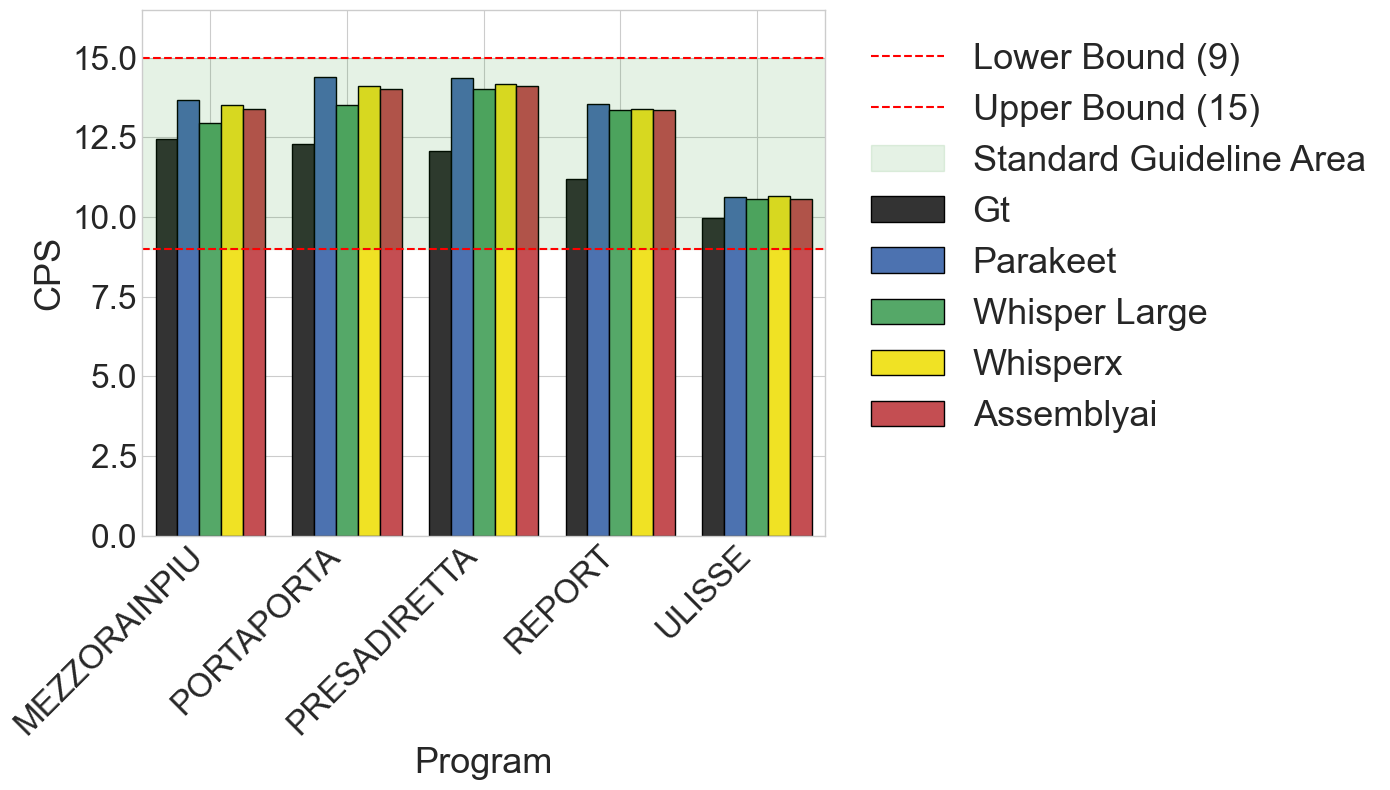

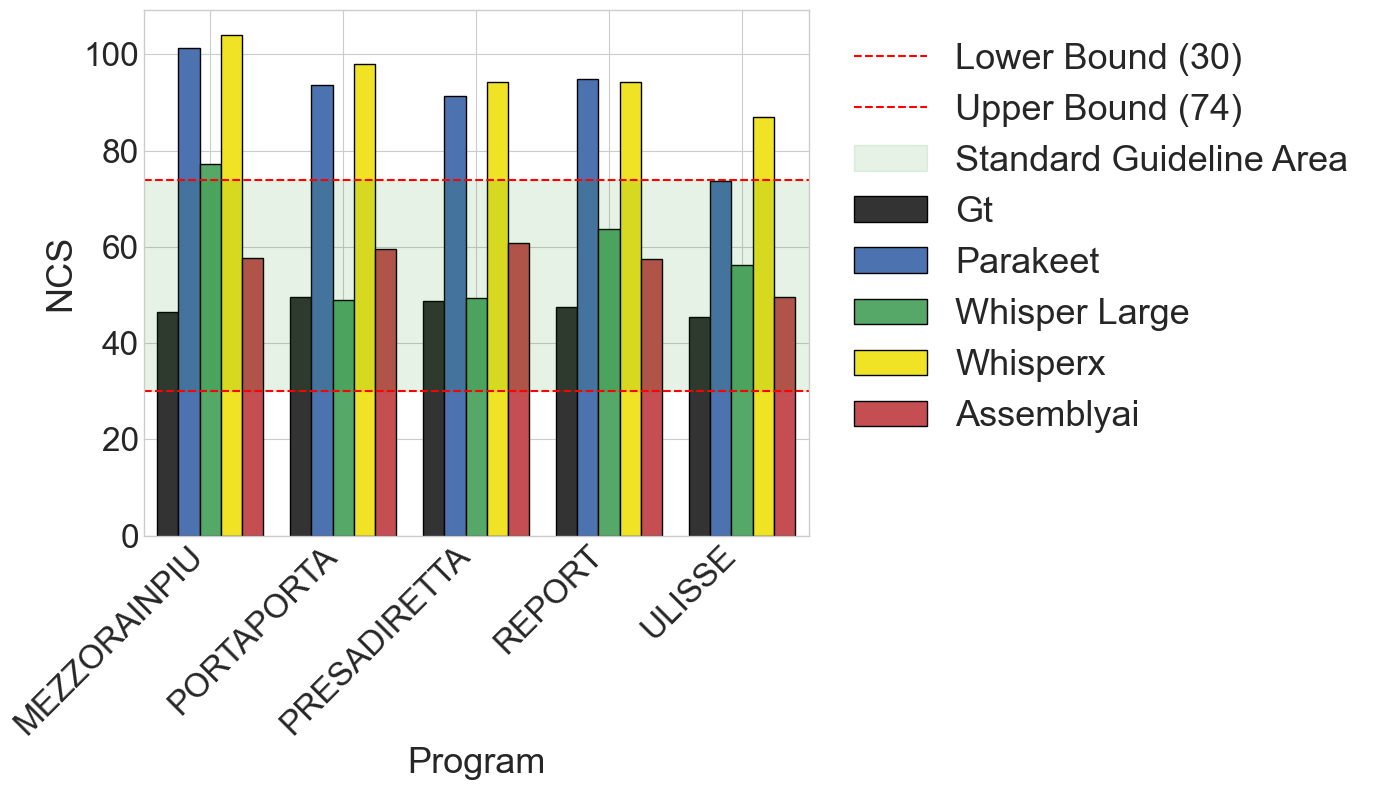

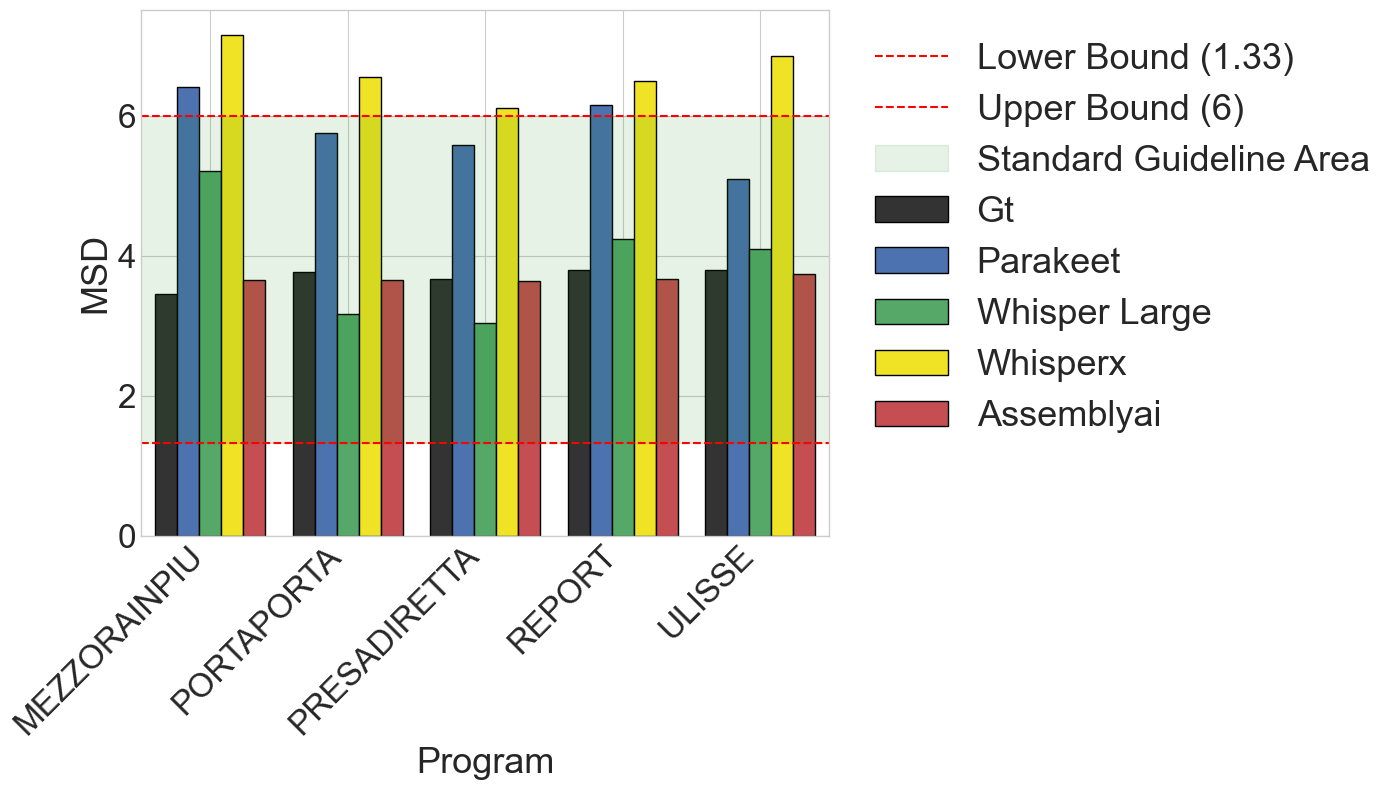

In [21]:
plot_aggregated_metric_by_program(readability_stats, "CPS")
plot_aggregated_metric_by_program(readability_stats, "NUM_CHARS_SEGMENTS")
plot_aggregated_metric_by_program(readability_stats, "MEAN_SEGMENT_DURATION")

Metriche qualitative dopo aver applicato la funzione per migliorare la leggibilità (**IMPROVED SRT**)

In [22]:
srt_directories = [f"../data/{model}/improved_srt" for model in models]
srt_directories.insert(0,f"../data/srt/ground-truth-cleaned" )


all_subtitles = load_all_subtitles(srt_directories)

# Verifica esempio:
print(f"Caricati {len(all_subtitles)} file SRT")
print(f"Esempio: primo modello = {all_subtitles[0][0]} primo file = {all_subtitles[0][1]}, numero segmenti = {len(all_subtitles[0][2])}")

Caricati 150 file SRT
Esempio: primo modello = srt primo file = MEZZORAINPIU_10_10_21.srt, numero segmenti = 540


In [23]:
readability_stats = build_statistics_dataset(all_subtitles)

In [24]:
readability_stats = readability_stats.rename(columns={'srt_CPS':'gt_CPS', 'srt_MEAN_SEGMENT_DURATION':'gt_MEAN_SEGMENT_DURATION', 'srt_NUM_CHARS_SEGMENTS':'gt_NUM_CHARS_SEGMENTS'})
readability_stats = readability_stats.reindex(columns=['gt_CPS','parakeet_CPS','whisper_large_CPS','whisperx_CPS','assemblyai_CPS','gt_MEAN_SEGMENT_DURATION','parakeet_MEAN_SEGMENT_DURATION','whisper_large_MEAN_SEGMENT_DURATION','whisperx_MEAN_SEGMENT_DURATION','assemblyai_MEAN_SEGMENT_DURATION', 'gt_NUM_CHARS_SEGMENTS', 'parakeet_NUM_CHARS_SEGMENTS','whisper_large_NUM_CHARS_SEGMENTS','whisperx_NUM_CHARS_SEGMENTS','assemblyai_NUM_CHARS_SEGMENTS'])

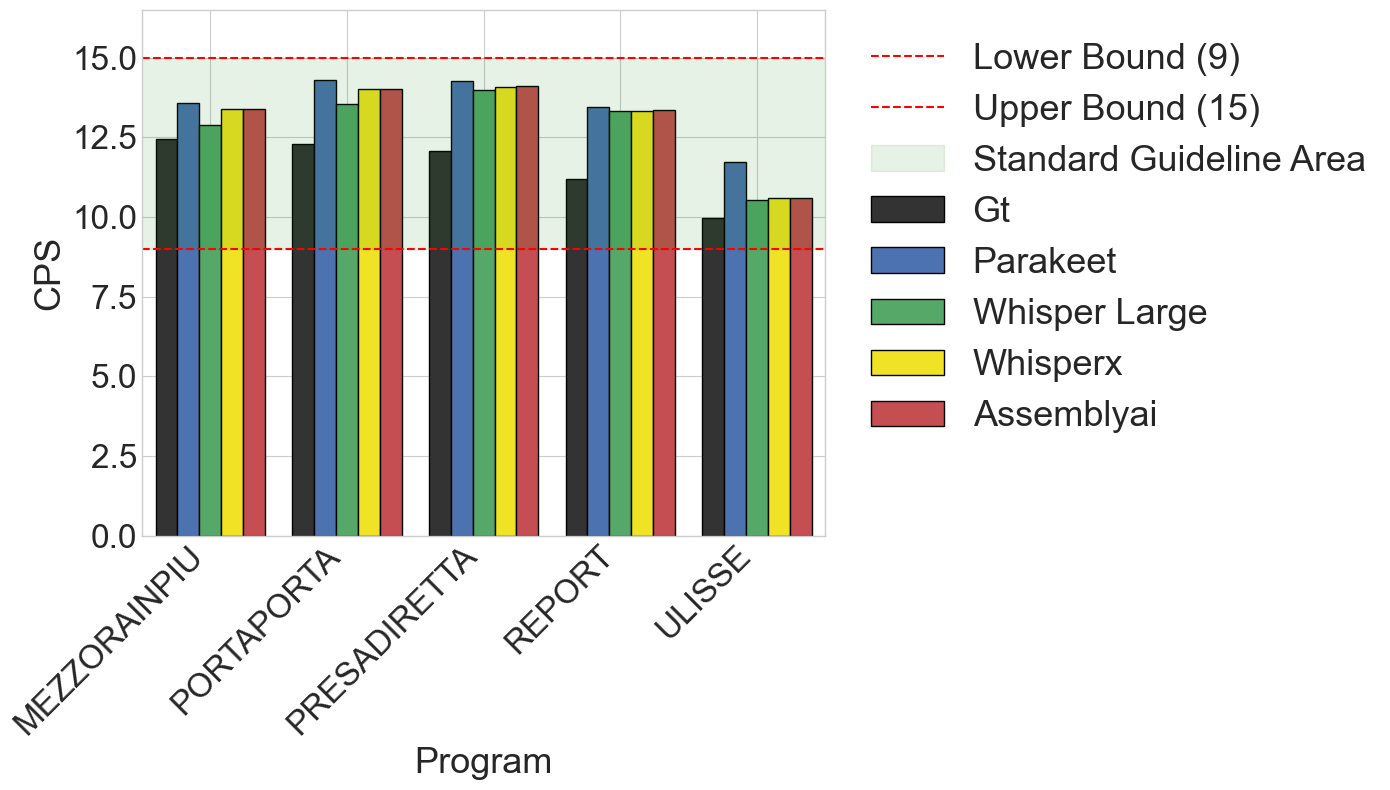

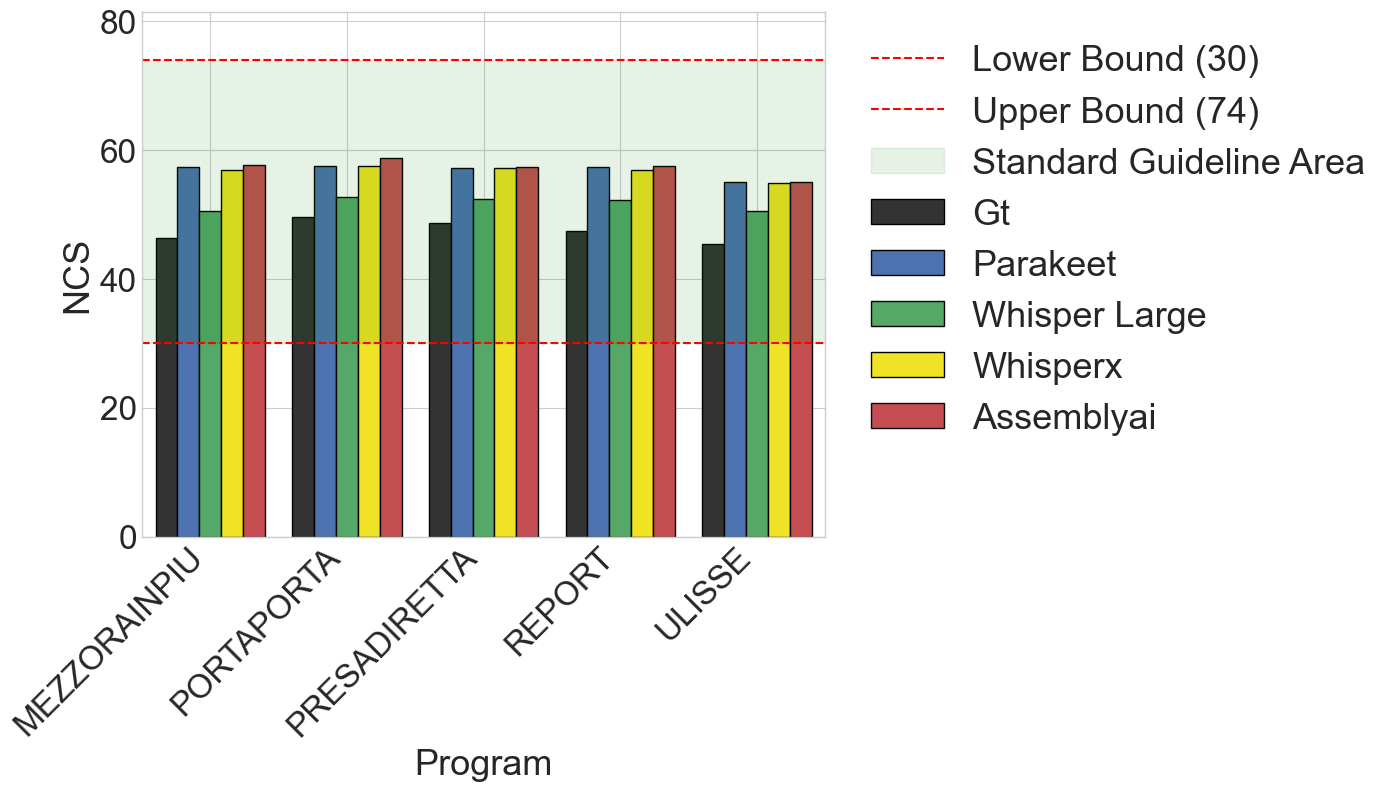

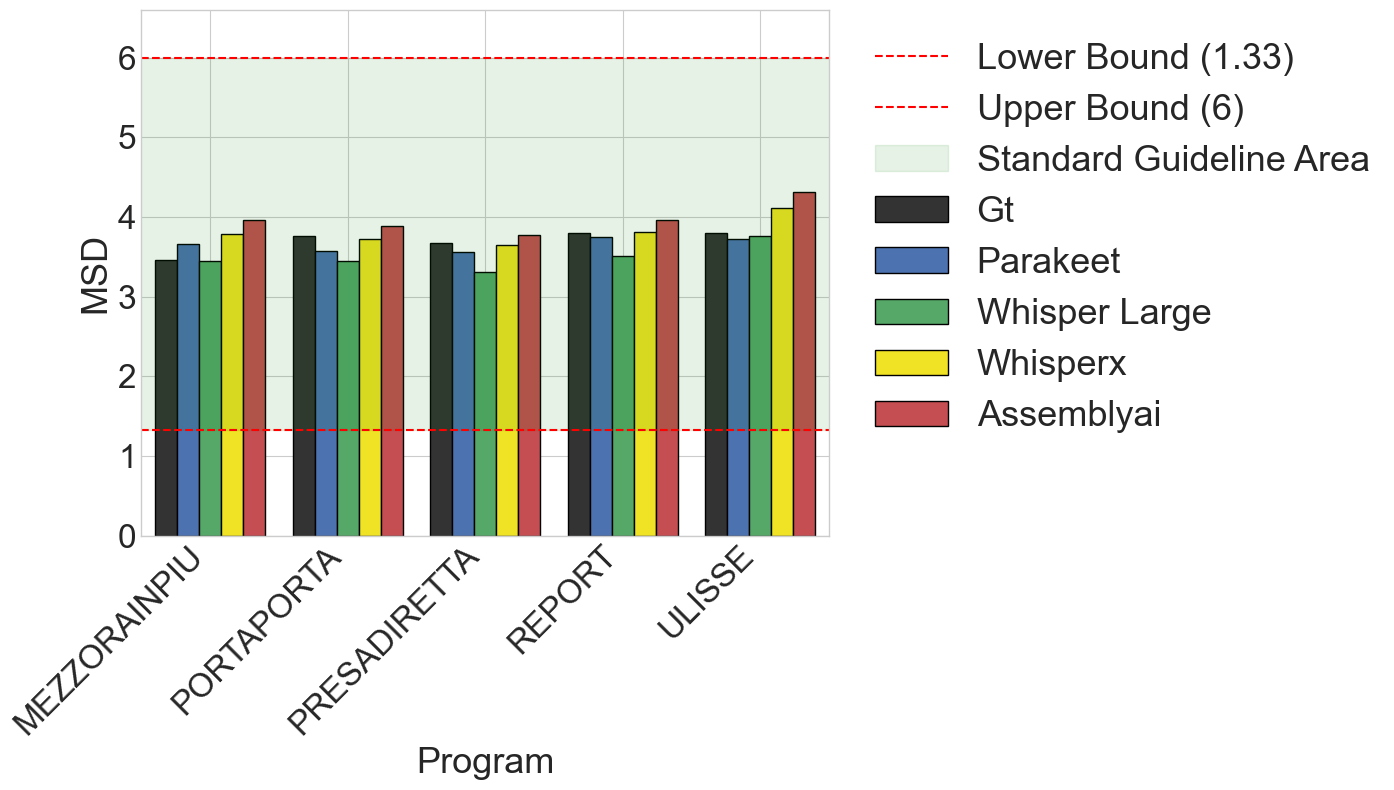

In [25]:
plot_aggregated_metric_by_program(readability_stats, "CPS")
plot_aggregated_metric_by_program(readability_stats, "NUM_CHARS_SEGMENTS")
plot_aggregated_metric_by_program(readability_stats, "MEAN_SEGMENT_DURATION")